<a href="https://colab.research.google.com/github/justkittenaround/Working-Parts/blob/master/GeneticAlgorithm_Sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up the Program  
  
First, let's import some python libraries and functions we will need. 

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
problem = np.array([
0,4,0,0,0,0,1,7,9,
0,0,2,0,0,8,0,5,4,
0,0,6,0,0,5,0,0,8,
0,8,0,0,7,0,9,1,0,
0,5,0,0,9,0,0,3,0,
0,1,9,0,6,0,0,4,0,
3,0,0,4,0,0,7,0,0,
5,7,0,1,0,0,2,0,0,
9,2,8,0,0,0,0,6,0])

In [ ]:
problem = np.array([
0,0,0,0,0,3,0,1,7,
0,1,5,0,0,9,0,0,8,
0,6,0,0,0,0,0,0,0,
1,0,0,0,0,7,0,0,0,
0,0,9,0,0,0,2,0,0,
0,0,0,5,0,0,0,0,4,
0,0,0,0,0,0,0,2,0,
5,0,0,6,0,0,3,4,0,
3,4,0,2,0,0,0,0,0])

In [ ]:
problem = np.array([
1,0,0,0,0,7,0,9,0,
0,3,0,0,2,0,0,0,8,
0,0,9,6,0,0,5,0,0,
0,0,5,3,0,0,9,0,0,
0,1,0,0,8,0,0,0,2,
6,0,0,0,0,4,0,0,0,
3,0,0,0,0,0,0,1,0,
0,4,0,0,0,0,0,0,7,
0,0,7,0,0,0,3,0,0])

In [ ]:
def print_sudoku(state):
    border = "------+-------+------"
    rows = [state[i:i+9] for i in range(0,81,9)]
    for i,row in enumerate(rows):
        if i % 3 == 0:
            print(border)
        three = [row[i:i+3] for i in range(0,9,3)]
        print(" | ".join(
            " ".join(str(x or "_") for x in one)
            for one in three
        ))
    print(border)



In [ ]:
fixed = np.where(problem)[0]

In [ ]:
fixed

array([ 0,  5,  7, 10, 13, 17, 20, 21, 24, 29, 30, 33, 37, 40, 44, 45, 50,
       54, 61, 64, 71, 74, 78])

In [ ]:
print_sudoku(problem)

------+-------+------
1 _ _ | _ _ 7 | _ 9 _
_ 3 _ | _ 2 _ | _ _ 8
_ _ 9 | 6 _ _ | 5 _ _
------+-------+------
_ _ 5 | 3 _ _ | 9 _ _
_ 1 _ | _ 8 _ | _ _ 2
6 _ _ | _ _ 4 | _ _ _
------+-------+------
3 _ _ | _ _ _ | _ 1 _
_ 4 _ | _ _ _ | _ _ 7
_ _ 7 | _ _ _ | 3 _ _
------+-------+------


# Defining the Functions  
Now that the rough structure of a basic GA has been illustrated, and we have loaded in an image we want to reproduce and imported python libraries, we are now ready to define the functions needed for the GA. 

### Initializing the Population  
Typically each individual is initialized with random values from some set of numbers. Since we are trying to reproduce an image, we chose random values from the range [0, 255].

In [ ]:
#defines where each larger square in the model is
def block_indices(block_num):
    firstrow = (block_num // 3) * 3
    firstcol = (block_num % 3) * 3
    indices = [ 9*(firstrow+i) + (firstcol+j) for i in range(3) for j in range(3)]
    return indices

In [ ]:
#start with a random guess for each postion
def randomize_on_zeros(problem):
    solution = problem.copy()
    for block in range(9):
        indices = block_indices(block)
        block = problem[indices]
        zeros = [i for i in indices if problem[i] == 0]
        to_fill = [i for i in range(1, 10) if i not in block]
        random.shuffle(to_fill)
        for index, value in zip(zeros, to_fill):
            solution[index] = value
    return solution

In [ ]:
n = 100 #population size

In [ ]:
population = [randomize_on_zeros(problem) for i in range(n)]

In [ ]:
#evaluate the fitness of the random generated solution to the problem
#the lower the number, the better the fitness
def evaluate_fitness(x):
    #Counts duplicates in rows and cols
    x = x.reshape(9,9)
    L = 0
    for i in range(9):
        L += 9 - len(np.unique(x[i,:]))
        L += 9 - len(np.unique(x[:,i]))
    return L

In [ ]:
fitness_vals = [evaluate_fitness(x) for x in population]

In [ ]:
np.sum(fitness_vals), np.min(fitness_vals)

(4659, 33)

In [ ]:
def select(population, fitness_vals):
    n_discard = n // 2  # lower half of population to discard

    # sort the population based on the corresponding fitness values
    sorted_inds = [ind for _, ind in sorted(zip(fitness_vals, list(range(len(fitness_vals)))), key=lambda pair: pair[0])]

    # return the population with those rows removed
    return np.delete(population, sorted_inds[:n_discard], axis=0)

In [ ]:
s_p = select(population, fitness_vals)
parents = s_p.copy()
parents.shape

(50, 81)

In [ ]:
np.sum([evaluate_fitness(s_p[i]) for i in range(len(s_p))])

2490

In [ ]:
def reproduction(s_p):

    n_parents, n_genes = s_p.shape

    # get all combinations of parents
    combinations = [[p1, p2] for p1 in range(n_parents-1, 0, -1) for p2 in range(p1-1, -1, -1)]


    # select some of these combinations randomly for reproduction
    comb_sample = list(np.random.choice(len(combinations), size=(n_parents), replace=False))
    combinations = [comb for i, comb in enumerate(combinations) if i in comb_sample]

    # initialize an array to fill the children with
    children = np.zeros(s_p.shape)

    for i_comb, comb in enumerate(combinations):
        parent1, parent2 = s_p[comb]
        child = parent1.copy()

        # mask each parent's genes randomly with an equal probability
        A = [i for i in range(81) if i not in fixed]
        swap = np.random.choice(A, len(A)//2)
        child[swap] = parent2[swap]
        children[i_comb, :] = child

        return children

In [ ]:
children = reproduction(s_p)
children.shape

(50, 81)

In [ ]:
np.sum([evaluate_fitness(children[i]) for i in range(len(children))])

7104

In [ ]:
def mutate(children, num_muts):
    mutchil = np.zeros((len(children), 81))

    for i in range(len(children)):

        child = children[i].copy()
        
        A = [i for i in block_indices(random.randrange(9)) if i not in fixed] # Don't move starting numbers
        
        for idx in range(num_muts):
            m, n = random.sample(A, 2) #swap number within block

            child[m], child[n] = child[n], child[m]

        mutchil[i,] = child

    return mutchil

In [ ]:
children2 = mutate(children, 3)

In [ ]:
children2.shape

(50, 81)

In [ ]:
np.sum([evaluate_fitness(children2[i]) for i in range(len(children2))])

7106

In [ ]:
def make_next_generation(parents, children):
    next = np.concatenate((parents, children), 0)
    return next

In [ ]:
n_p = make_next_generation(parents, children2)
n_p.shape

(100, 81)

In [ ]:
np.sum([evaluate_fitness(n_p[i]) for i in range(len(n_p))]), np.min([evaluate_fitness(n_p[i]) for i in range(len(n_p))])

(9596, 46)

In [ ]:
print_sudoku(problem)

------+-------+------
1 _ _ | _ _ 7 | _ 9 _
_ 3 _ | _ 2 _ | _ _ 8
_ _ 9 | 6 _ _ | 5 _ _
------+-------+------
_ _ 5 | 3 _ _ | 9 _ _
_ 1 _ | _ 8 _ | _ _ 2
6 _ _ | _ _ 4 | _ _ _
------+-------+------
3 _ _ | _ _ _ | _ 1 _
_ 4 _ | _ _ _ | _ _ 7
_ _ 7 | _ _ _ | 3 _ _
------+-------+------


In [ ]:
print_sudoku(n_p[0].astype(int))

------+-------+------
1 8 2 | 8 3 7 | 3 9 2
6 3 5 | 5 2 4 | 4 7 8
7 4 9 | 6 1 9 | 5 1 6
------+-------+------
2 7 5 | 3 9 5 | 9 7 1
3 1 9 | 7 8 6 | 4 5 2
6 4 8 | 2 1 4 | 8 6 3
------+-------+------
3 8 1 | 4 9 1 | 4 1 2
9 4 2 | 3 5 2 | 9 8 7
6 5 7 | 7 6 8 | 3 5 6
------+-------+------


# Putting It All Together

Generation: 0; Best Fitness: 46


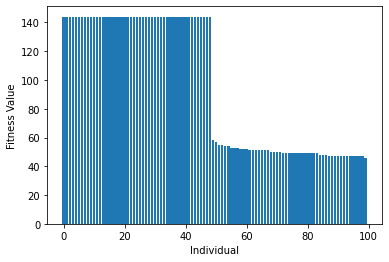

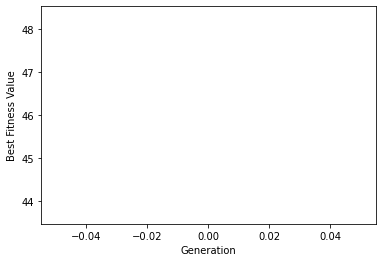

Generation: 2000; Best Fitness: 48


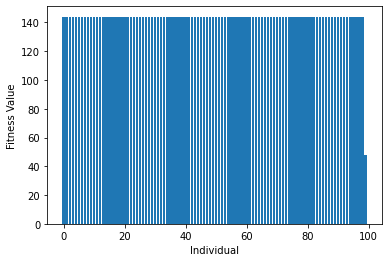

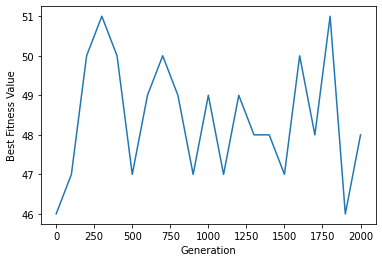

Generation: 4000; Best Fitness: 47


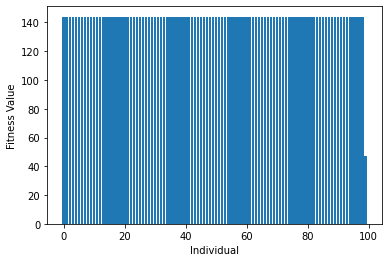

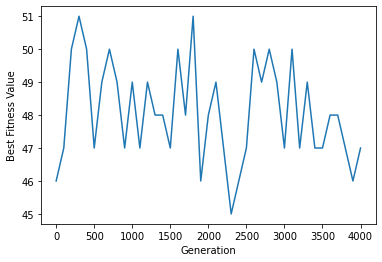

Generation: 6000; Best Fitness: 53


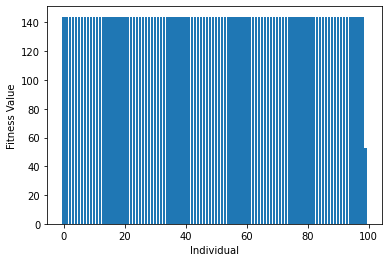

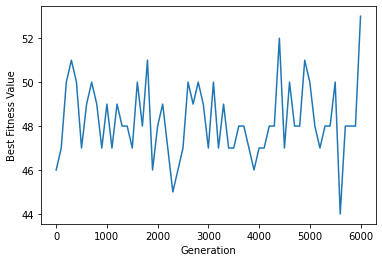

Generation: 8000; Best Fitness: 48


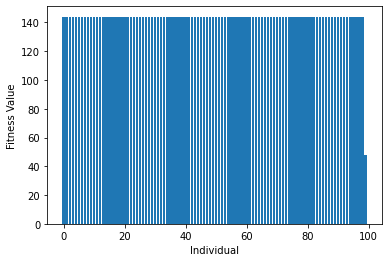

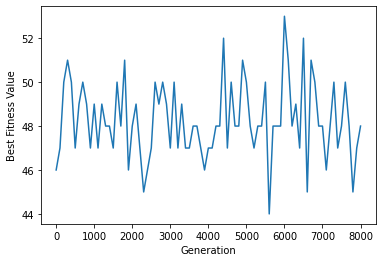

Generation: 10000; Best Fitness: 50


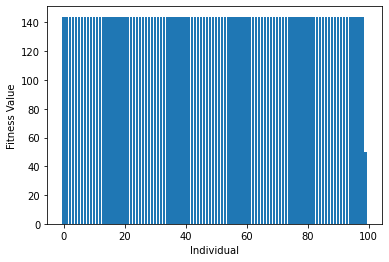

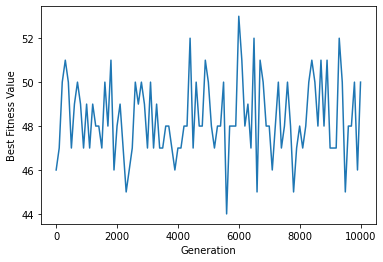

Generation: 12000; Best Fitness: 46


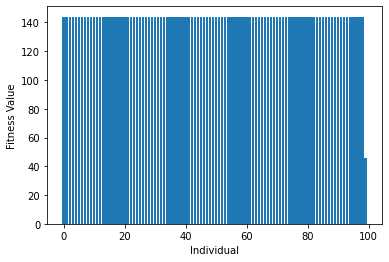

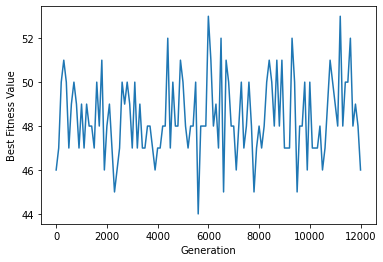

Generation: 14000; Best Fitness: 46


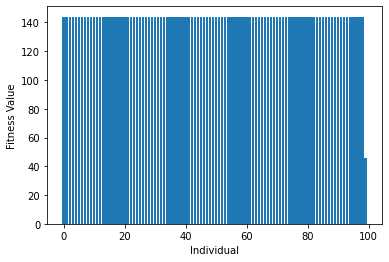

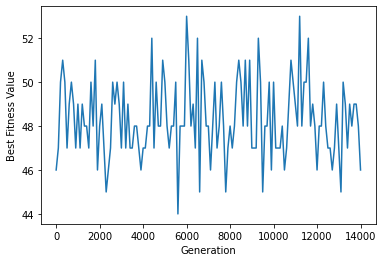

Generation: 16000; Best Fitness: 50


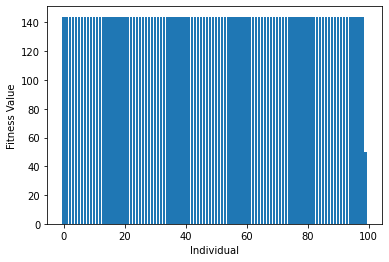

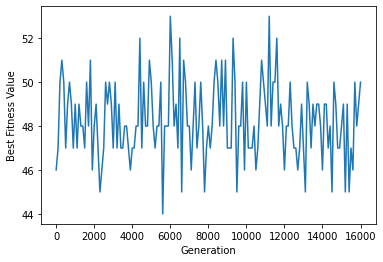

Generation: 18000; Best Fitness: 45


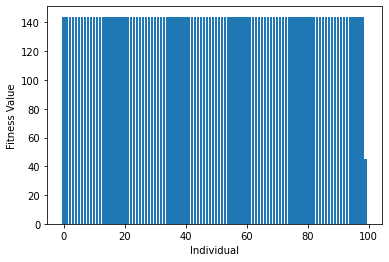

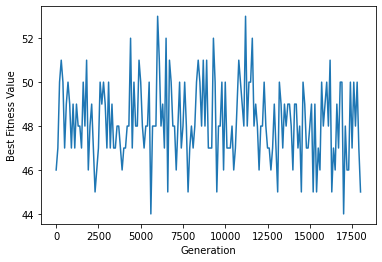

Generation: 20000; Best Fitness: 47


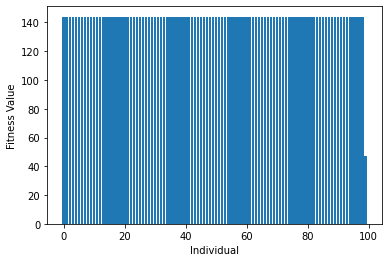

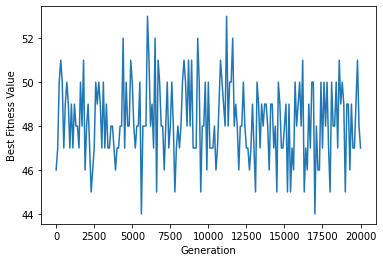

Generation: 22000; Best Fitness: 45


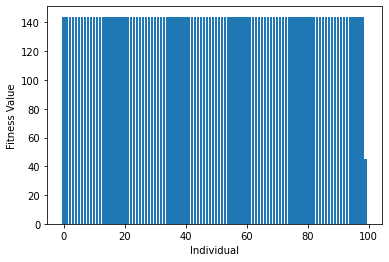

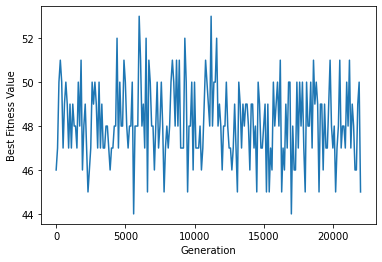

Generation: 24000; Best Fitness: 48


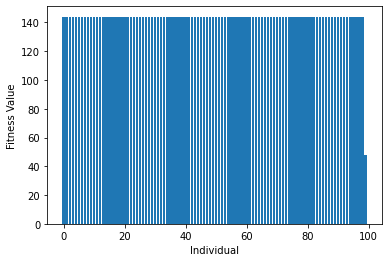

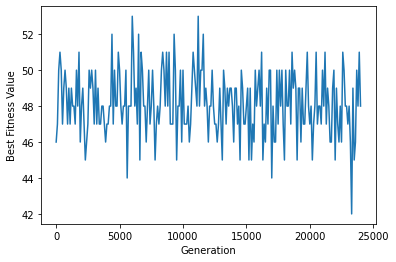

Generation: 26000; Best Fitness: 48


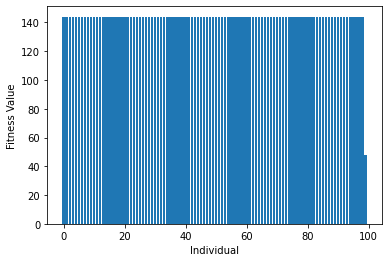

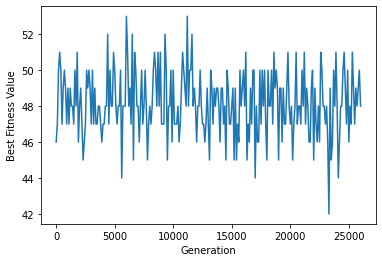

Generation: 28000; Best Fitness: 48


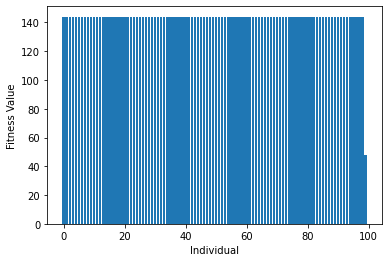

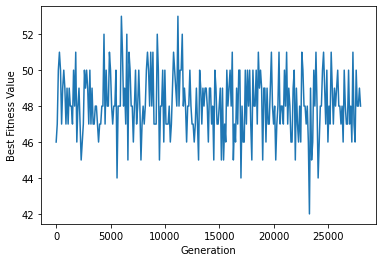

Generation: 30000; Best Fitness: 51


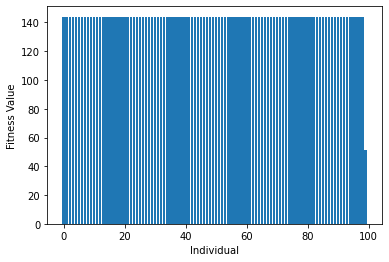

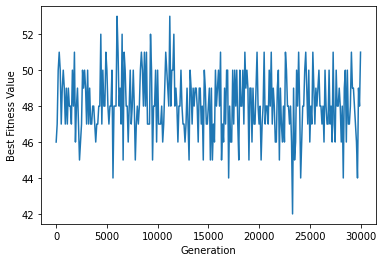

Generation: 32000; Best Fitness: 49


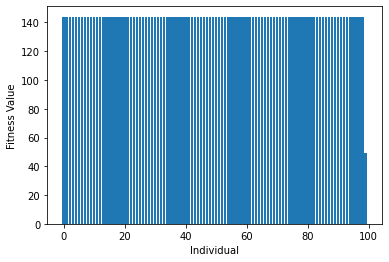

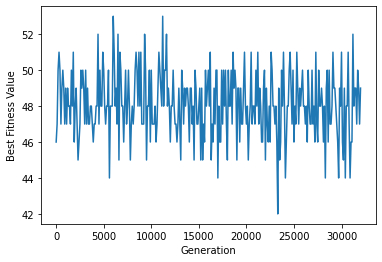

Generation: 34000; Best Fitness: 47


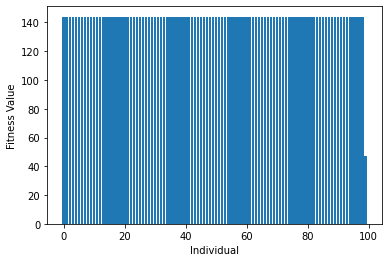

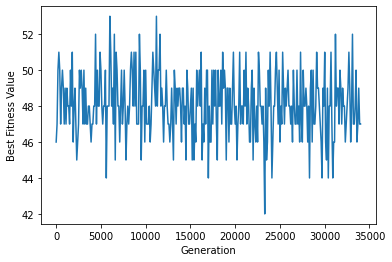

Generation: 36000; Best Fitness: 45


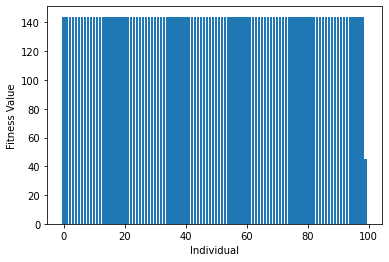

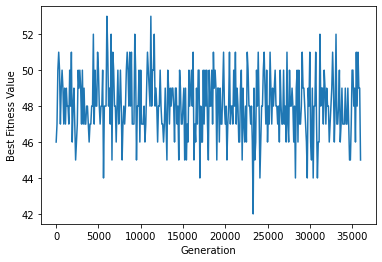

Generation: 38000; Best Fitness: 50


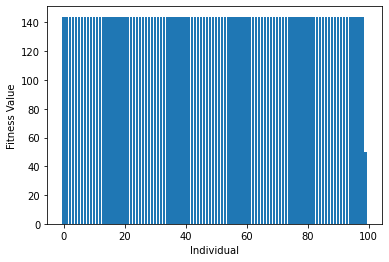

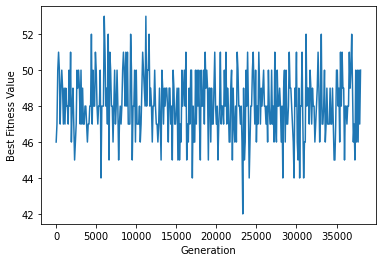

Generation: 40000; Best Fitness: 49


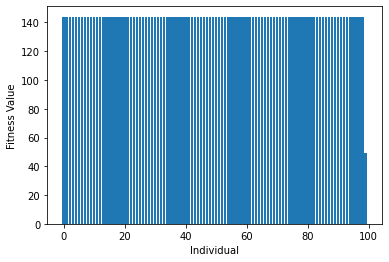

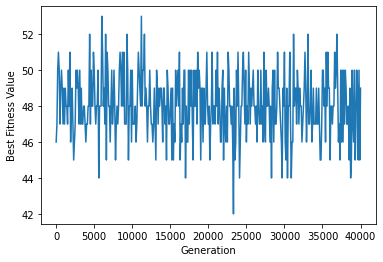

Generation: 42000; Best Fitness: 48


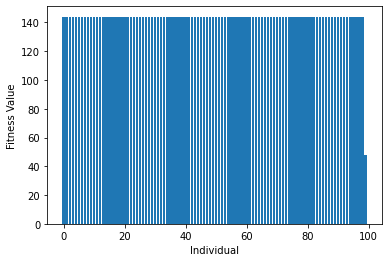

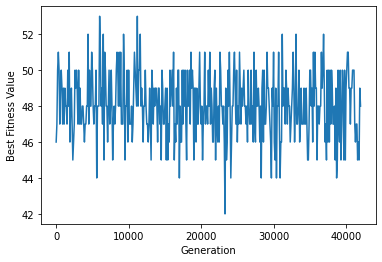

Generation: 44000; Best Fitness: 49


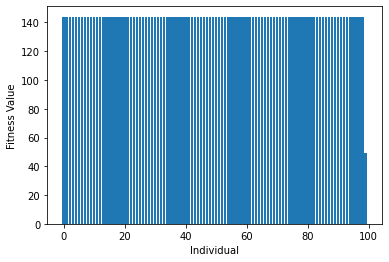

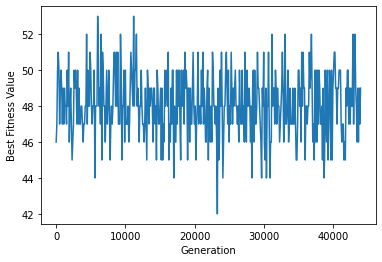

Generation: 46000; Best Fitness: 51


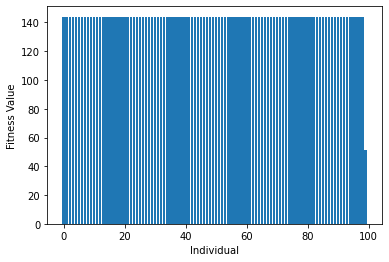

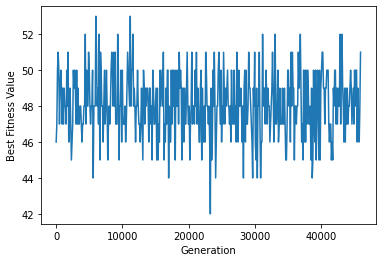

Generation: 48000; Best Fitness: 48


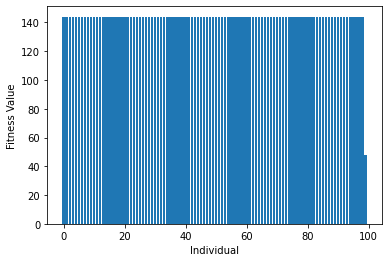

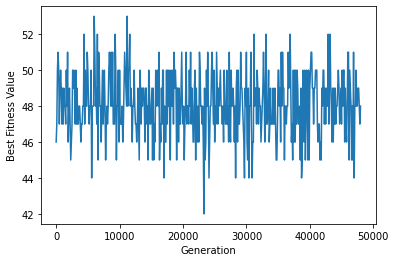

Generation: 50000; Best Fitness: 47


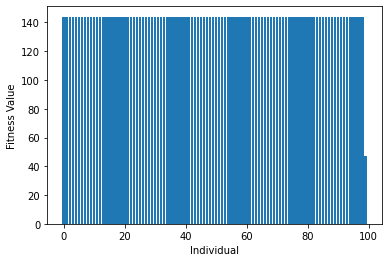

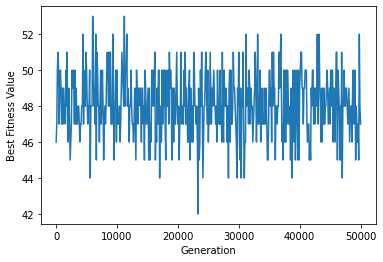

Generation: 52000; Best Fitness: 47


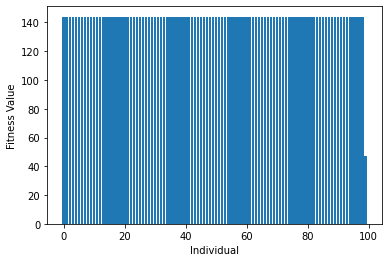

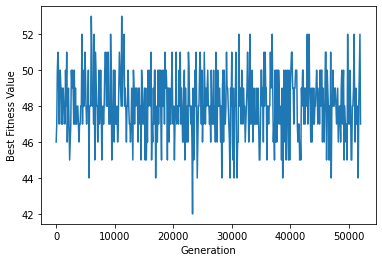

Generation: 54000; Best Fitness: 51


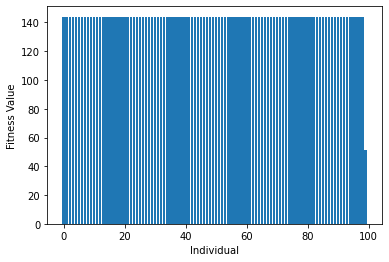

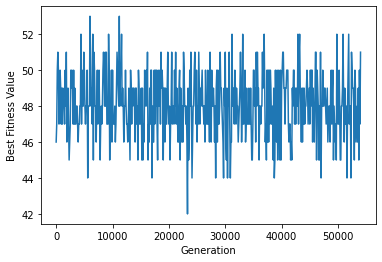

Generation: 56000; Best Fitness: 50


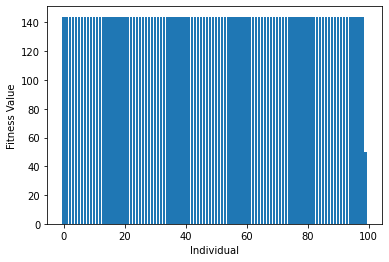

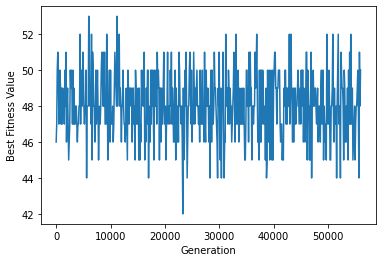

Generation: 58000; Best Fitness: 50


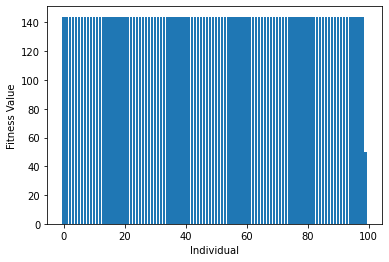

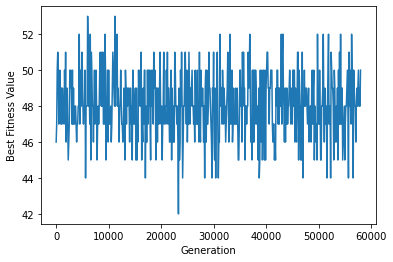

Generation: 60000; Best Fitness: 48


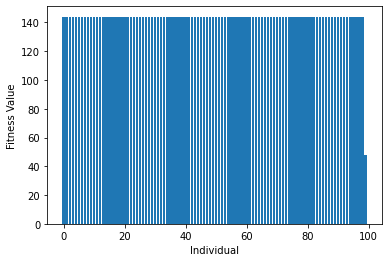

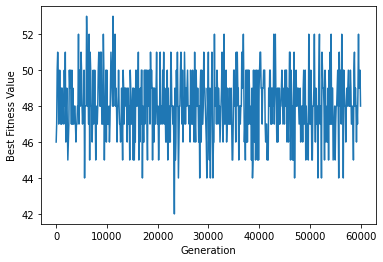

Generation: 62000; Best Fitness: 47


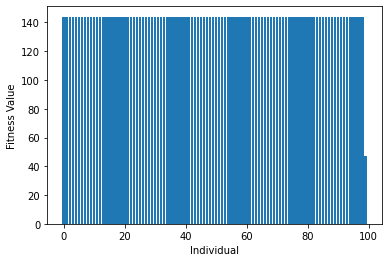

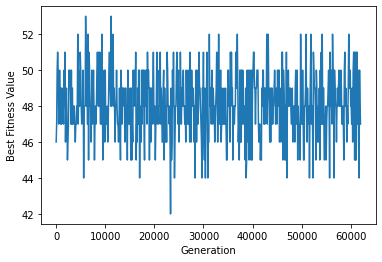

Generation: 64000; Best Fitness: 46


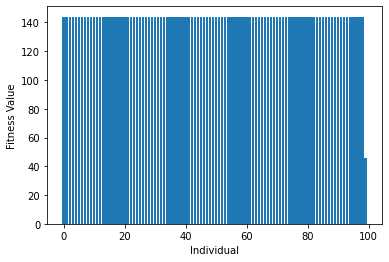

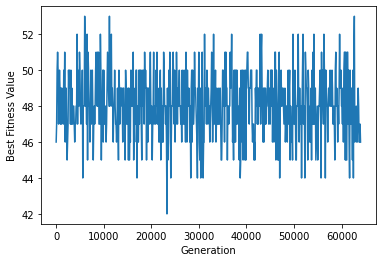

Generation: 66000; Best Fitness: 48


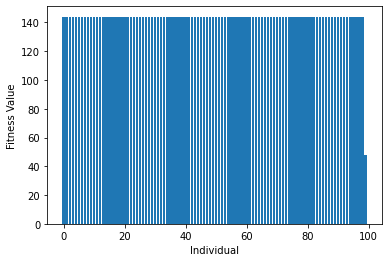

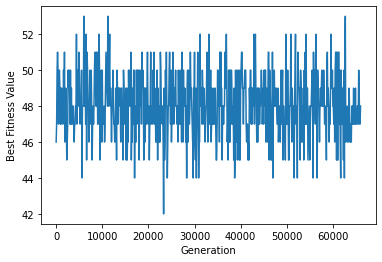

Generation: 68000; Best Fitness: 45


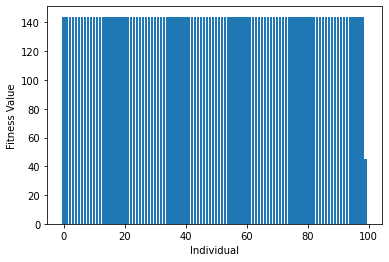

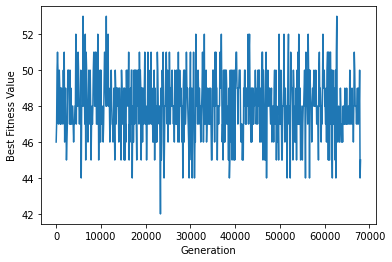

Generation: 70000; Best Fitness: 47


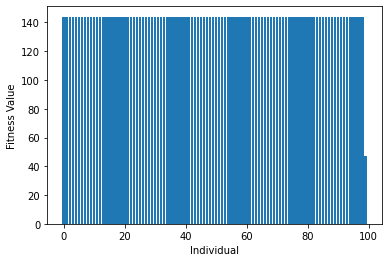

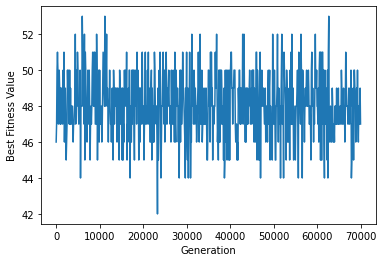

Generation: 72000; Best Fitness: 48


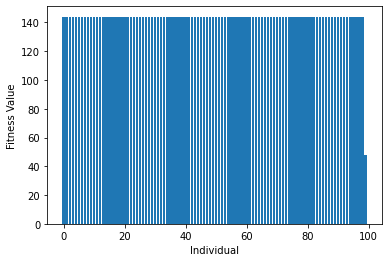

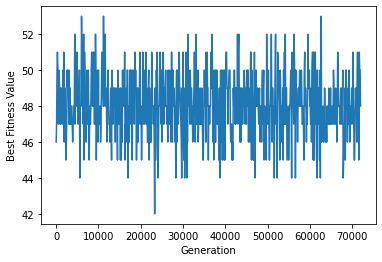

Generation: 74000; Best Fitness: 49


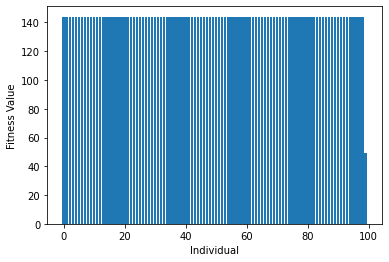

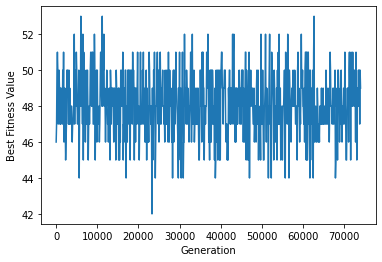

Generation: 76000; Best Fitness: 49


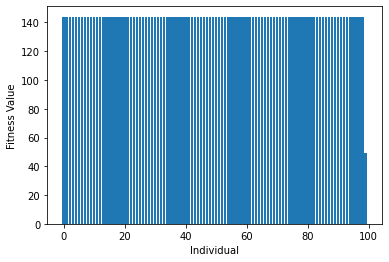

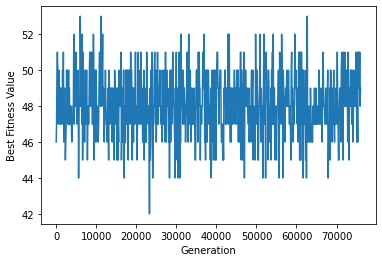

Generation: 78000; Best Fitness: 47


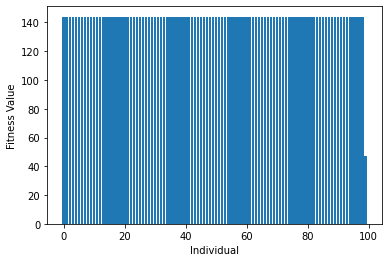

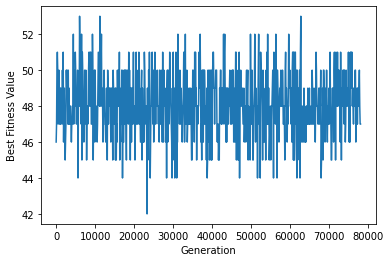

Generation: 80000; Best Fitness: 50


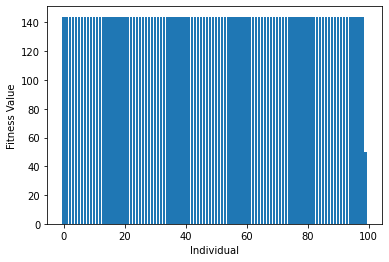

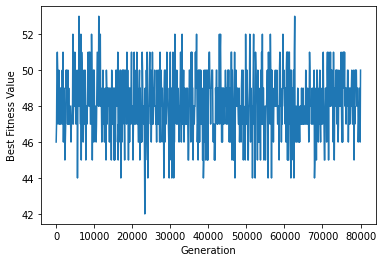

Generation: 82000; Best Fitness: 45


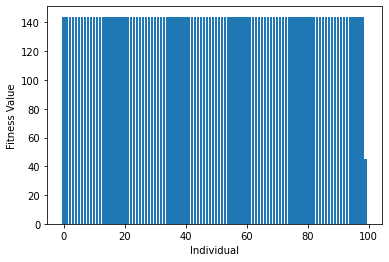

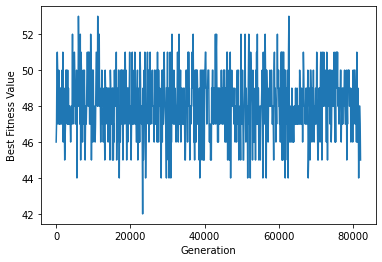

Generation: 84000; Best Fitness: 47


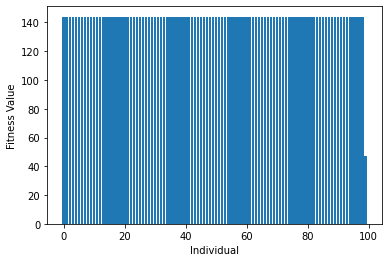

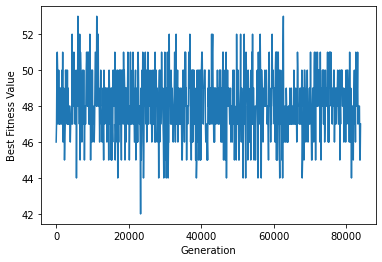

Generation: 86000; Best Fitness: 48


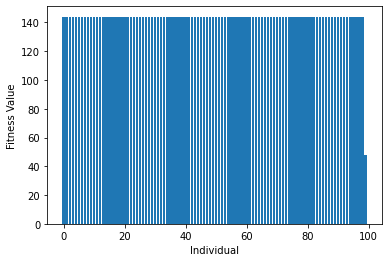

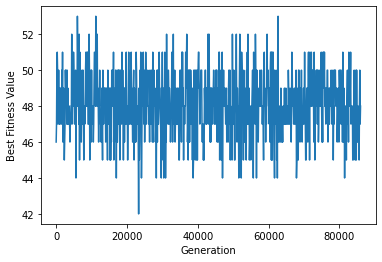

Generation: 88000; Best Fitness: 47


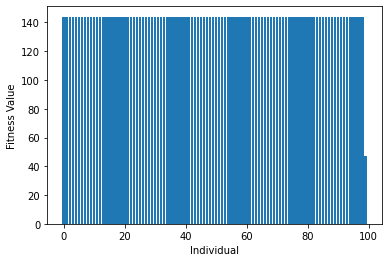

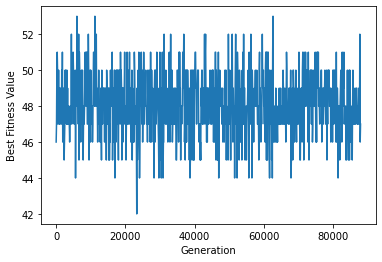

Generation: 90000; Best Fitness: 49


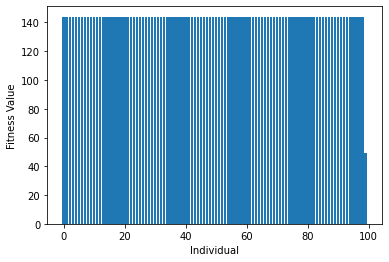

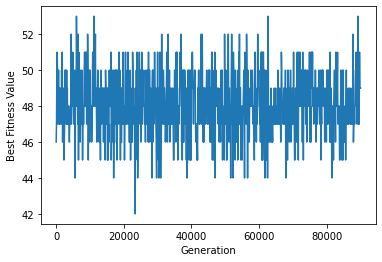

Generation: 92000; Best Fitness: 49


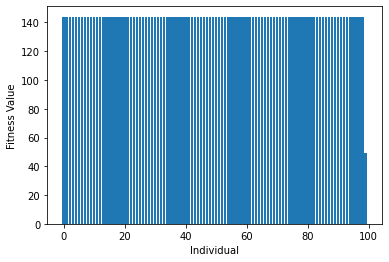

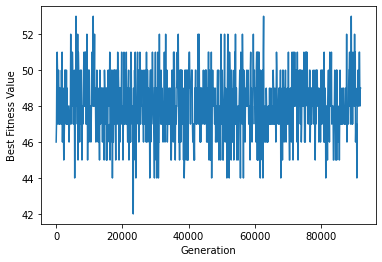

Generation: 94000; Best Fitness: 46


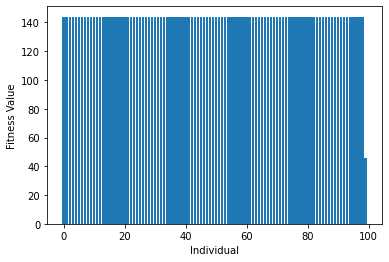

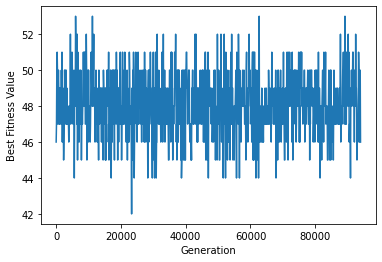

Generation: 96000; Best Fitness: 50


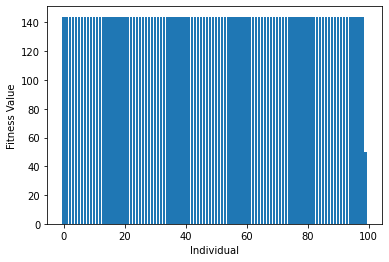

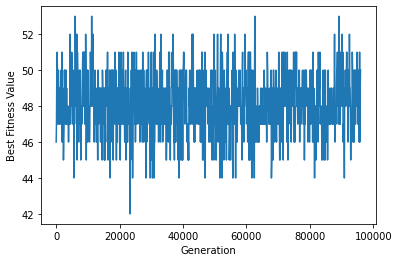

Generation: 98000; Best Fitness: 46


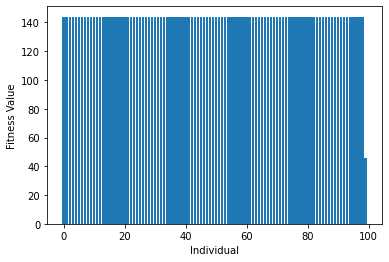

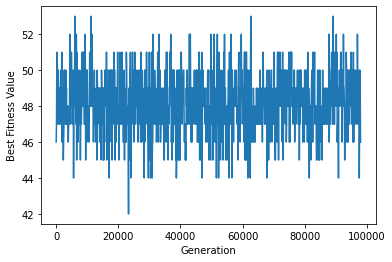

Generation: 100000; Best Fitness: 47


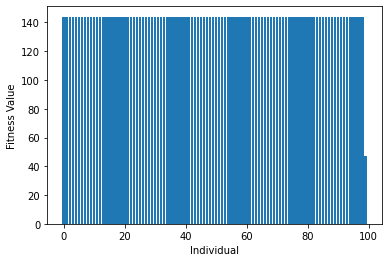

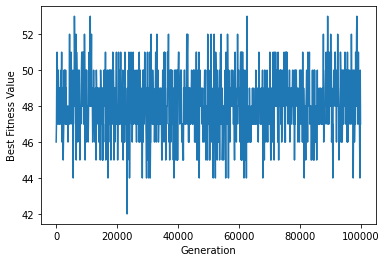

Generation: 102000; Best Fitness: 48


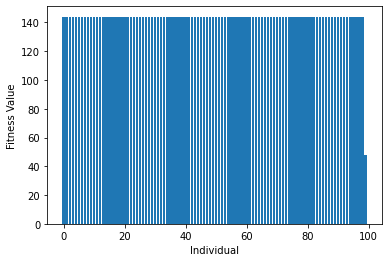

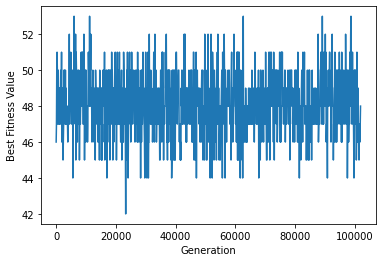

Generation: 104000; Best Fitness: 48


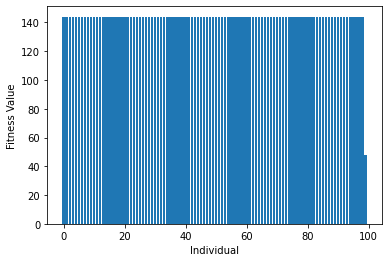

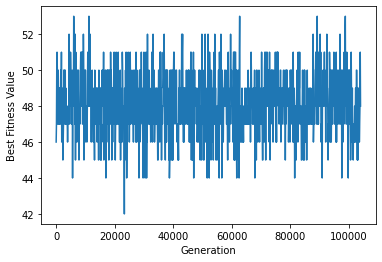

Generation: 106000; Best Fitness: 49


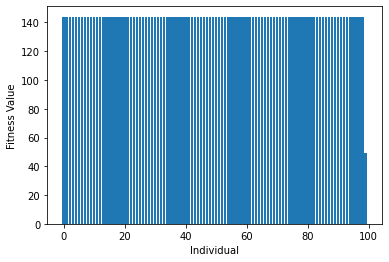

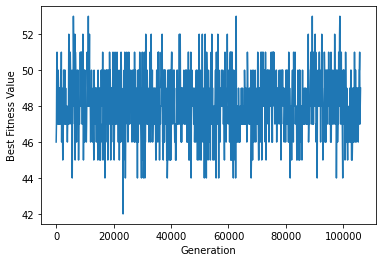

Generation: 108000; Best Fitness: 45


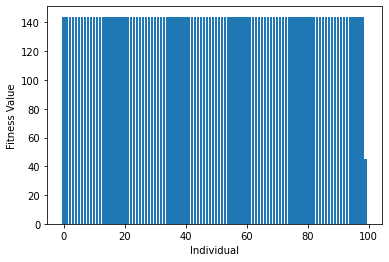

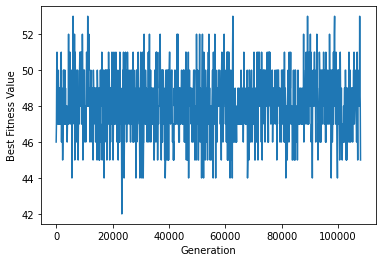

Generation: 110000; Best Fitness: 47


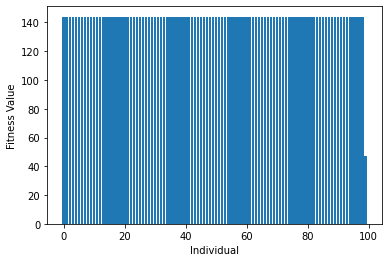

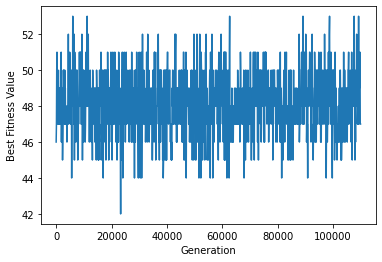

Generation: 112000; Best Fitness: 50


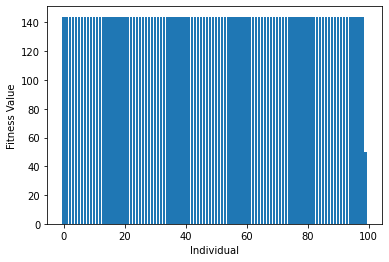

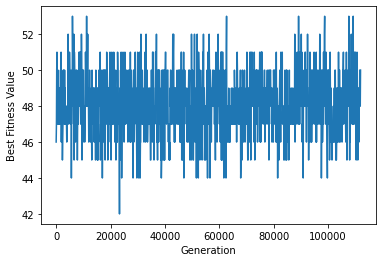

Generation: 114000; Best Fitness: 47


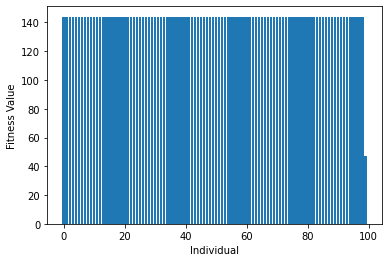

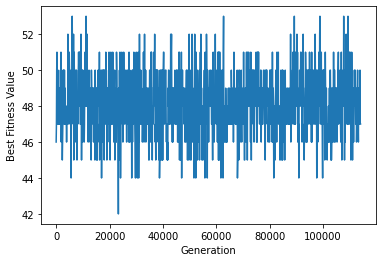

Generation: 116000; Best Fitness: 51


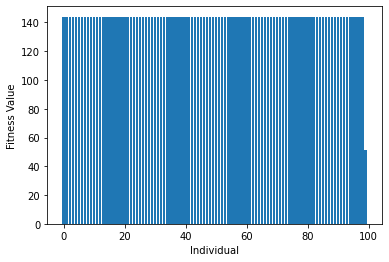

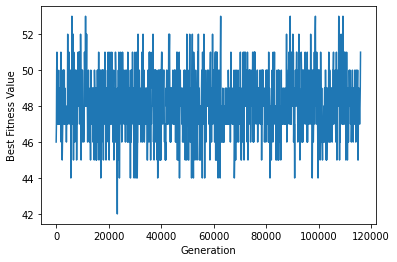

Generation: 118000; Best Fitness: 47


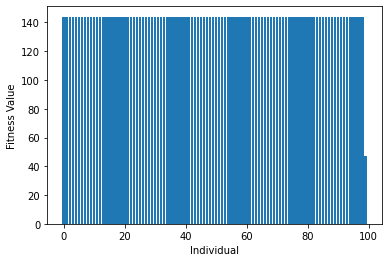

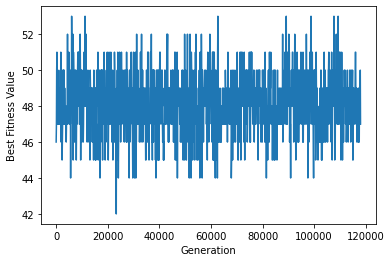

Generation: 120000; Best Fitness: 50


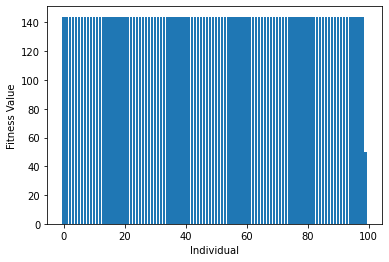

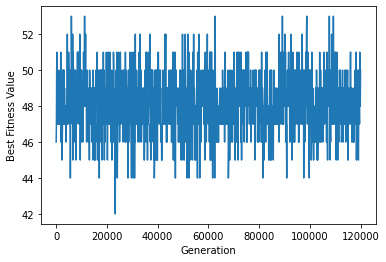

Generation: 122000; Best Fitness: 50


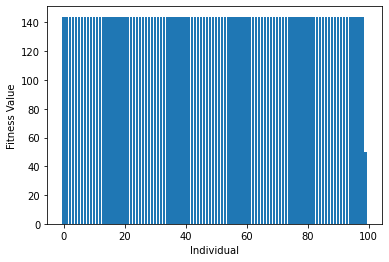

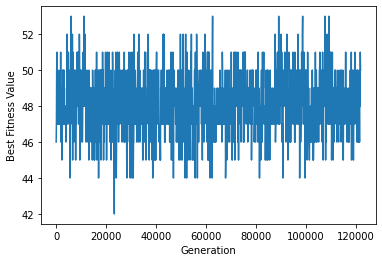

Generation: 124000; Best Fitness: 49


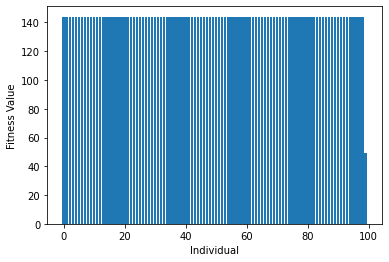

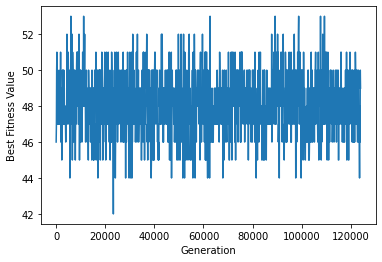

Generation: 126000; Best Fitness: 49


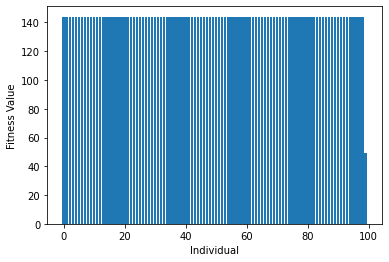

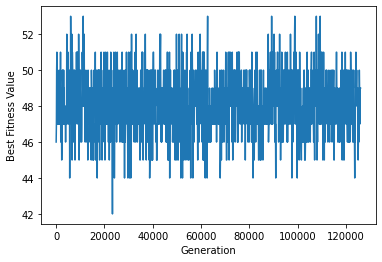

Generation: 128000; Best Fitness: 47


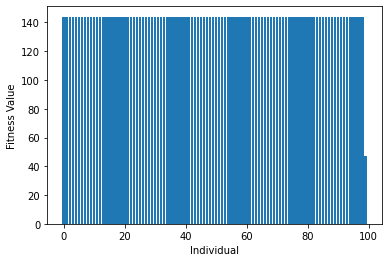

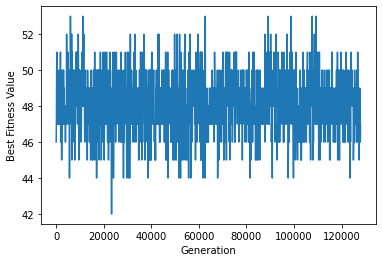

Generation: 130000; Best Fitness: 47


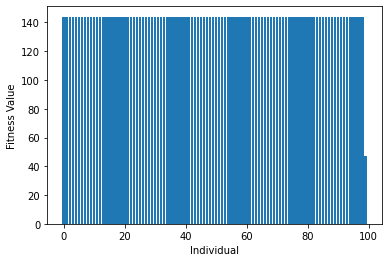

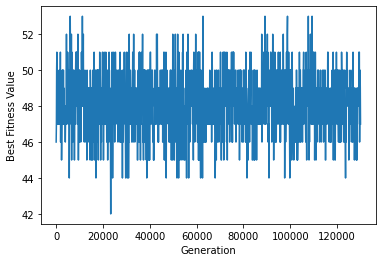

Generation: 132000; Best Fitness: 50


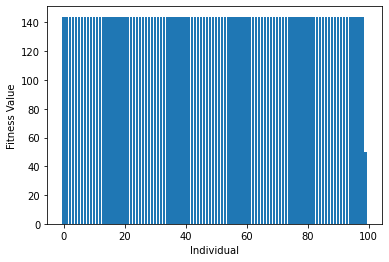

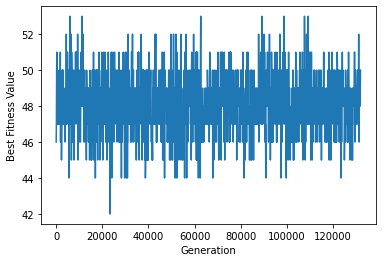

Generation: 134000; Best Fitness: 50


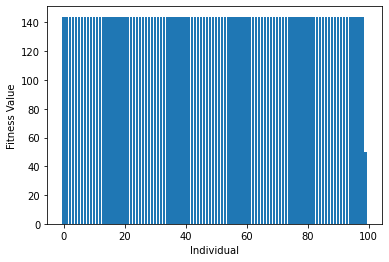

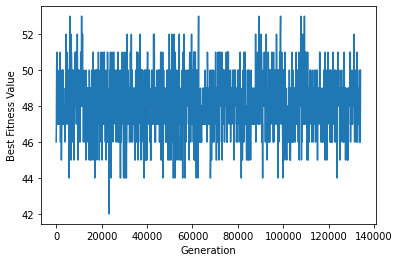

Generation: 136000; Best Fitness: 48


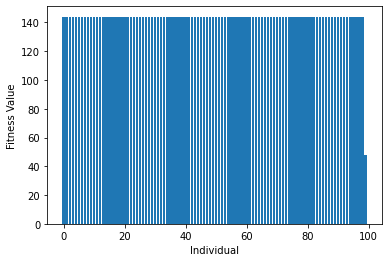

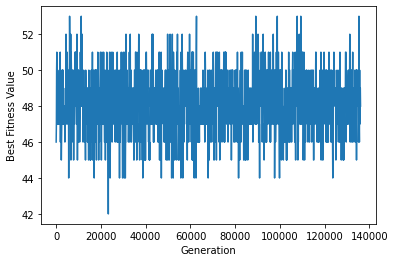

Generation: 138000; Best Fitness: 49


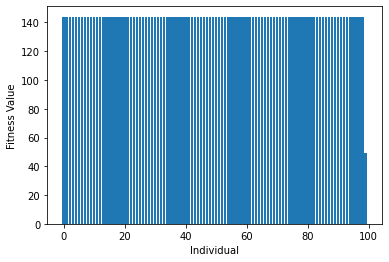

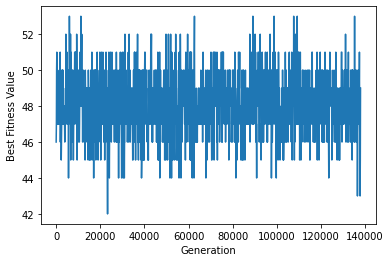

Generation: 140000; Best Fitness: 48


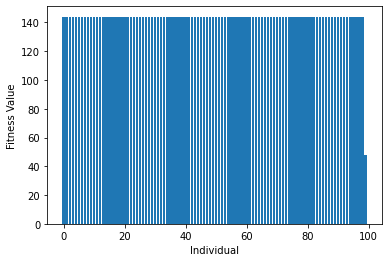

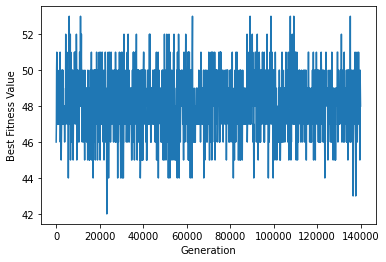

Generation: 142000; Best Fitness: 47


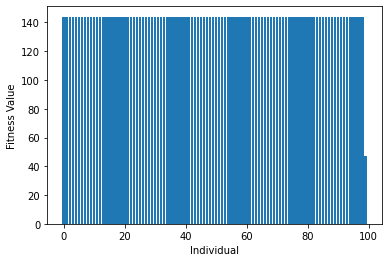

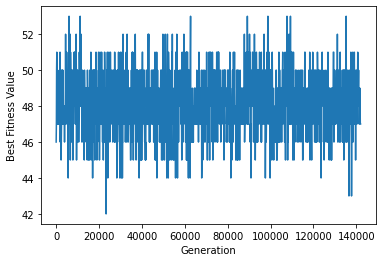

Generation: 144000; Best Fitness: 47


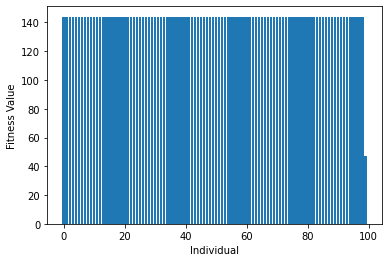

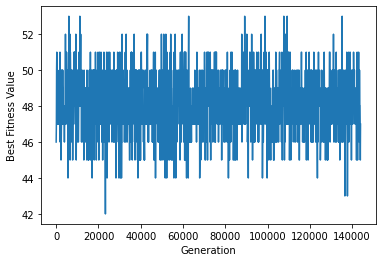

Generation: 146000; Best Fitness: 52


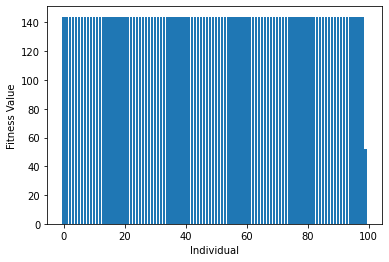

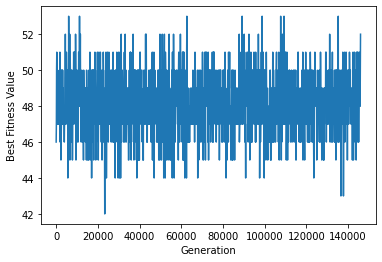

Generation: 148000; Best Fitness: 46


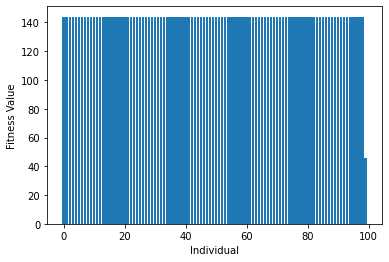

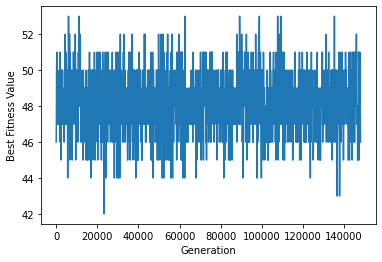

Generation: 150000; Best Fitness: 49


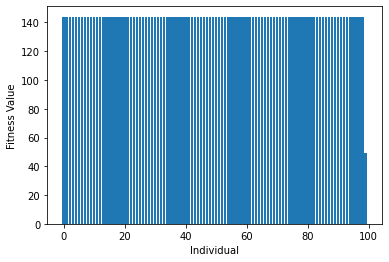

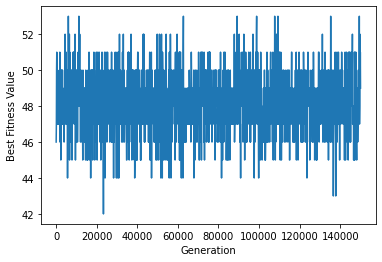

Generation: 152000; Best Fitness: 49


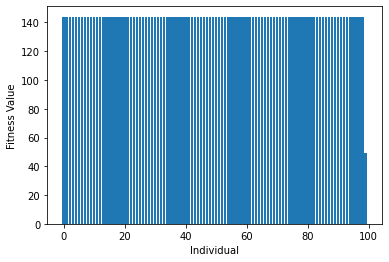

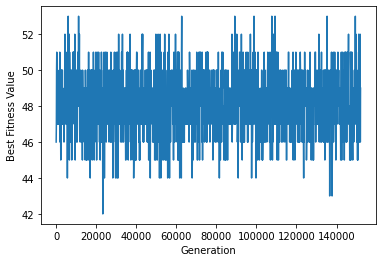

Generation: 154000; Best Fitness: 48


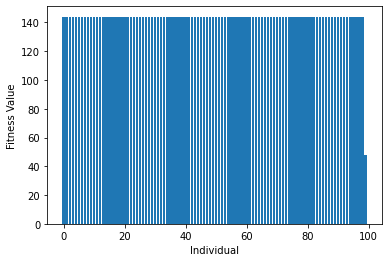

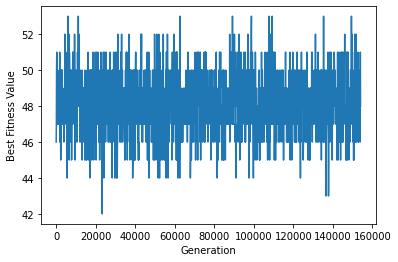

Generation: 156000; Best Fitness: 50


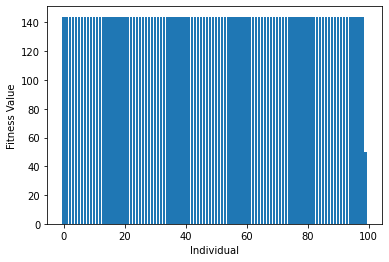

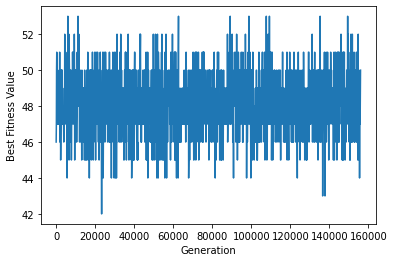

Generation: 158000; Best Fitness: 48


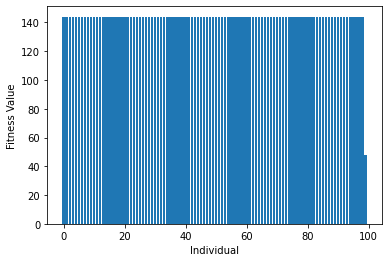

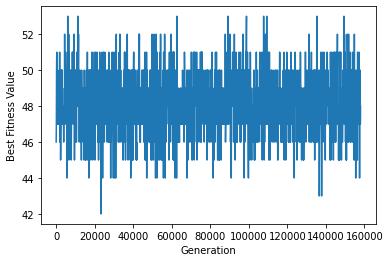

Generation: 160000; Best Fitness: 48


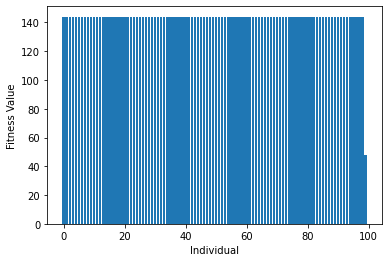

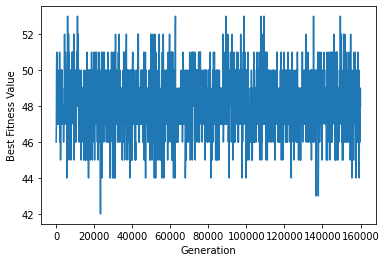

Generation: 162000; Best Fitness: 50


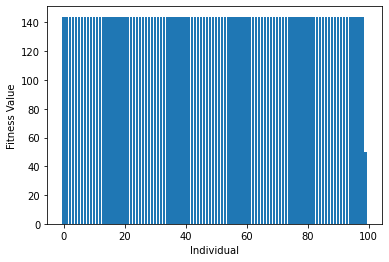

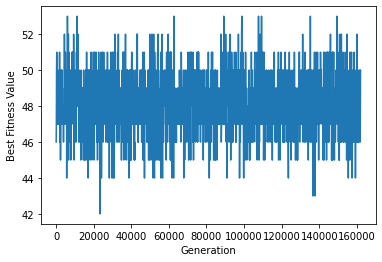

Generation: 164000; Best Fitness: 48


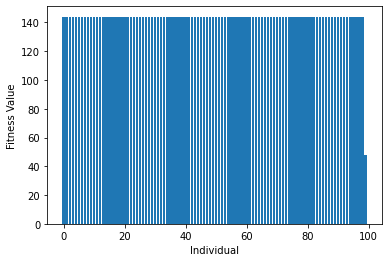

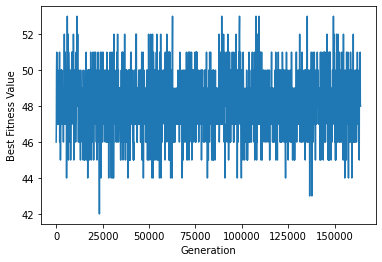

Generation: 166000; Best Fitness: 47


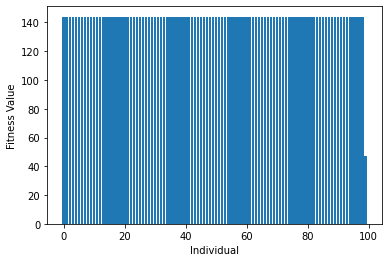

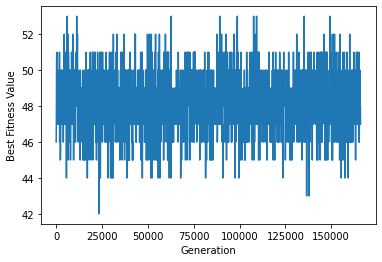

Generation: 168000; Best Fitness: 45


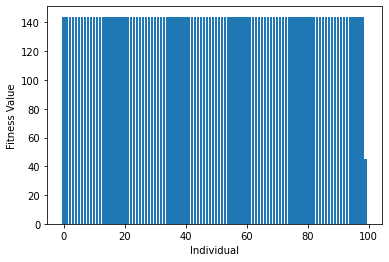

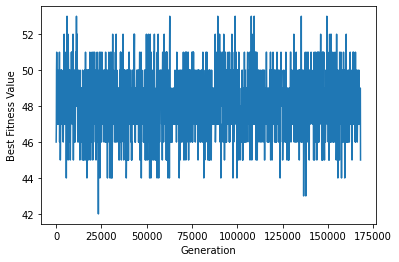

Generation: 170000; Best Fitness: 49


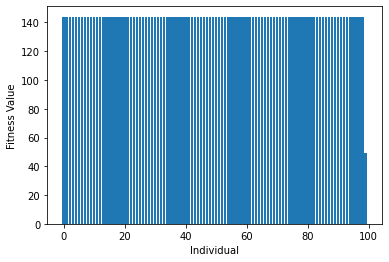

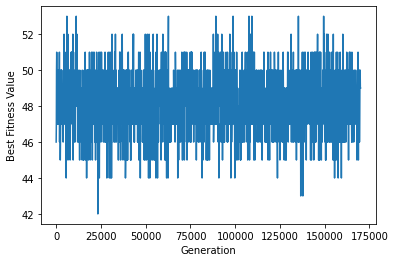

Generation: 172000; Best Fitness: 44


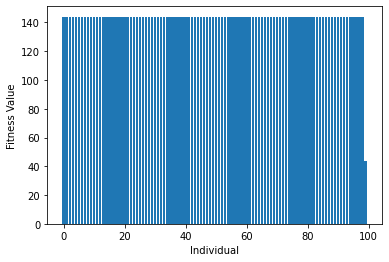

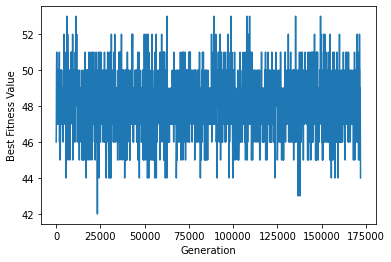

Generation: 174000; Best Fitness: 52


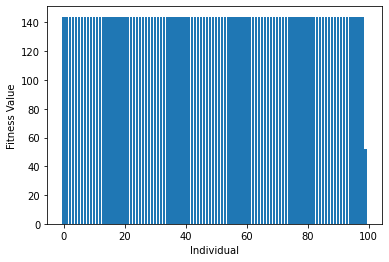

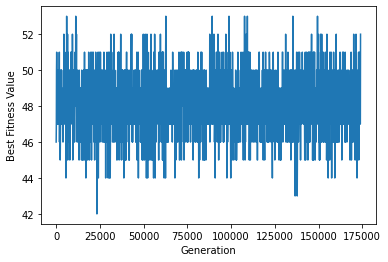

In [ ]:
generation = 0
best_fitness = []  # going to track the max fitness values in this list
desired_fitness = 10  # keep going until the max fitness equals or exceeds 0.9
n = 100 

population = [randomize_on_zeros(problem) for i in range(n)]

fitness_vals = [evaluate_fitness(x) for x in population]

while min(fitness_vals) > desired_fitness:
    population2 = select(population, fitness_vals)
    parents = population2.copy()
    chilren = reproduction(population2)
    children2 = mutate(children, 3)
    population = make_next_generation(parents, children2)
    fitness_vals = [evaluate_fitness(x) for x in population]

    # plotting metrics and progress
    if generation % 100 == 0:
        best_fitness.append([generation, min(fitness_vals)])
    
    if generation % 2000 == 0: 
        print('Generation: {}; Best Fitness: {}'.format(generation, min(fitness_vals)))

        plt.bar(x = list(range(len(fitness_vals))), height = sorted(fitness_vals, reverse=True))
        plt.xlabel("Individual")
        plt.ylabel("Fitness Value")
        plt.show()

        plt.plot([x[0] for x in best_fitness], [x[1] for x in best_fitness])
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness Value")
        plt.show()

    generation += 1

In [ ]:
print_sudoku(problem)

In [ ]:
print_sudoku(n_p[np.argmax([evaluate_fitness(x) for x in n_p])].astype(int))

##Simulated Annealing

In [ ]:
#use simmulated annealing to find the best state according to the rules
best = 100
best_state = state
for T in cooling_schedule:

    state2 = move(state)

    delta = f(state) - f(state2) 

    if delta > 0 or  np.exp( delta / T) > np.random.random():

        state = state2
        
        if f(state) < best:
            best = f(state)
            best_state = state
            print(f(state))
            if best == 0:
                break